item-based sander en hugo

In [23]:
import json
from pandas import Series, Timestamp
import pandas as pd
from pandas import DataFrame
from numpy import nan
import sklearn.metrics.pairwise as pw
import numpy as np
import matplotlib.pyplot as plt




In [6]:
def load_jsons(data_path, file):
    """ helper function to load '.json' files (they're not proper jsons) """
    file_path = data_path + file
    with open(file_path) as jsons:
        lines = [json.loads(json_line) for json_line in jsons]
    return pd.DataFrame(lines)

In [7]:
data_path = '../data/brossard/'
review_file = 'review.json'
reviews = load_jsons(data_path, review_file)

display(reviews.head())

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Ccc3ZAXEw69lGZg5oAZKHw,YZ7S0_eemKwWR5tHkaMUqw,JD55YRLwptXJVkMRekbzNg,2.0,0,0,0,Average food and service. Kind of dirty and so...,2017-08-16 04:35:11
1,aZOOTcXB28ftRZJnQDMjjA,UiU_yqwSQwTZdw3vxD_Aag,JD55YRLwptXJVkMRekbzNg,4.0,0,0,0,Probably one of the best Vietnamese restaurant...,2017-12-02 20:13:24
2,9qRSlEj4Rcd3NXektgI1hA,vu9dmqZiZSm3ijUP-7HmKA,VvZnozdEpjw0e7Dg-kKIxg,4.0,0,0,0,"Petit restaurant, déco un peu vieillote, mais ...",2014-10-27 03:10:16
3,KTcqaTj8sHT0zJ0V-p1Kjg,S-t12afI5gGgVWZTV3iQNQ,n2dhdtnOzqeAKSn6s3nQSw,2.0,0,0,0,"We went there on a friday night, the whole pla...",2017-01-14 21:20:25
4,22vF44g9TIDsQOpmvVVg6A,_FKhZ0r6uTBNHA_ALWyGqg,KE7cmEKW8IwMFAdmzP72rQ,1.0,1,0,0,Pour un restaurant Italien qui pense que Sauce...,2015-06-08 19:09:25


In [8]:
def split_data(data, d = 0.75):
    np.random.seed(seed=5)
    mask_test = np.random.rand(data.shape[0]) < d
    return data[mask_test], data[~mask_test]

reviews_training, reviews_test = split_data(reviews, d=0.9)

In [12]:
def pivot_ratings(df):
    return df.pivot_table(values='stars', columns='user_id', index='business_id')

def create_similarity_matrix_cosine(matrix):
    mc_matrix = matrix - matrix.mean(axis = 0)
    return pd.DataFrame(pw.manhattan_distances(mc_matrix.fillna(0)), index = matrix.index, columns = matrix.index)

In [13]:
review_utitity_ratings = pivot_ratings(reviews_training)
display(review_utitity_ratings.head())

user_id,-01y5njeBMu1eAdIKdGG1g,-0SqALqeWmInVftG_iHcHg,-41z9zaHp6oONyUNfMDZjw,-5rgQfe0j-0AGl4B9g7DQg,-B4Cf2XLkPr9qMlLPHJAlw,-HHyrZ15Yr-3vDfo087n0A,-HMryuf0scfllObkYFF0hg,-LdOcazGWhUVrrLNpUgfvQ,-MlnpvmMOE9lb3noLlr6bQ,-OnlG_cVLxqUS_2_gCYqhA,...,ysnP1M717ewk8-BjxpzJOQ,zHvAuiMHZEgoXHFDMfszKw,zLkbxR1IvwnEbbztvZDfmw,zUFamSWdxK0qUS7Uwajf9g,zWWcik1fRPZviBCQLC26FQ,zg-C8Gu-tZq_RVoZhUOMQw,zhg-j5H6UsCd_DnpvNIprA,zhoytEzEitvTtUfXU99cIA,zmhC7E1NGHNGf0ITtsxGuw,ztnFttrQ7Rz5neGMcFsXxg
business_id,,,,,,,,,,,,,,,,,,,,,
-L9vtxgF0CZ25z-8HqHfDg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-juOL0eJC6kvf5RLEjoPvA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,3.0,NaN,1.0,NaN,NaN,NaN
-yEFjBrxf2r_BQzRnczzdw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1blpPH0_3jk2EnRz_Q_CuQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1h3aXVtJLx2o4mArNuhf2w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0


In [14]:
review_similarity_ratings = create_similarity_matrix_cosine(review_utitity_ratings)
display(review_similarity_ratings.head(50))

business_id,-L9vtxgF0CZ25z-8HqHfDg,-juOL0eJC6kvf5RLEjoPvA,-yEFjBrxf2r_BQzRnczzdw,1blpPH0_3jk2EnRz_Q_CuQ,1h3aXVtJLx2o4mArNuhf2w,2LRt7Y2-eqpbeDWO2BsPMg,2VAH-mSQXRNpaXysiLtm0Q,2lG2I1LyN6rCiw9U6wKtQg,2nGab5EU6uEmhlI_ovplOw,3M7MWfMh5RSoASV23-6hEw,...,vHJlN629vOqgI40noEOdlw,xBWn8DSwxzwkWL4JhfzP2g,xLDU3RQ1Ni_wTioEib_VIQ,xMhPyj9NEKEUpcWQMjpqKQ,xVNdvQQFV7pLfHe6xZ41dQ,yBkgxB_vpwYdsg4WqObRXA,yEzyioaCCZlvlEstY9LNEQ,yYzZScLRg1tNaZZrlz1Z3A,yvYCSzQm9tjZoBV_gJS7bQ,zHzV2hmXsRYxDNAxvPOVKw
business_id,,,,,,,,,,,,,,,,,,,,,
-L9vtxgF0CZ25z-8HqHfDg,0.000000,26.571717,3.325397,1.966667,11.494486,3.839286,1.696429,5.334804,11.166228,2.350000,...,9.765152,8.749364,4.700000,3.279762,3.300000,2.300000,15.232143,5.988889,19.507307,14.128571
-juOL0eJC6kvf5RLEjoPvA,26.571717,0.000000,26.897114,25.538384,34.316203,27.411003,25.268145,26.803580,32.272155,25.921717,...,33.336868,29.027664,28.271717,26.851479,26.871717,25.871717,37.303860,29.560606,41.136716,32.450288
-yEFjBrxf2r_BQzRnczzdw,3.325397,26.897114,0.000000,2.292063,11.819883,3.736111,2.021825,5.660201,11.491625,2.675397,...,10.090548,9.074761,5.025397,3.605159,3.625397,2.625397,15.557540,6.314286,19.404132,14.025397
1blpPH0_3jk2EnRz_Q_CuQ,1.966667,25.538384,2.292063,0.000000,10.461153,2.805952,0.663095,4.301471,10.132895,1.316667,...,8.731818,7.282698,3.666667,2.246429,2.266667,1.266667,13.265476,4.455556,18.040640,13.095238
1h3aXVtJLx2o4mArNuhf2w,11.494486,34.316203,11.819883,10.461153,0.000000,12.083772,10.190915,13.829290,18.460714,10.144486,...,17.059638,17.243851,13.194486,11.774248,11.794486,10.794486,22.238534,14.483375,26.317582,22.623058
2LRt7Y2-eqpbeDWO2BsPMg,3.839286,27.411003,3.736111,2.805952,12.083772,0.000000,2.535714,6.174090,12.005514,3.189286,...,10.604437,9.588650,5.539286,4.119048,4.139286,3.139286,15.821429,6.828175,19.918021,14.539286
2VAH-mSQXRNpaXysiLtm0Q,1.696429,25.268145,2.021825,0.663095,10.190915,2.535714,0.000000,4.031232,9.862657,1.046429,...,8.461580,7.445793,3.396429,1.583333,1.996429,0.996429,13.535714,4.685317,17.810878,12.825000
2lG2I1LyN6rCiw9U6wKtQg,5.334804,26.803580,5.660201,4.301471,13.829290,6.174090,4.031232,0.000000,12.751032,4.684804,...,12.099955,10.731227,7.034804,5.614566,5.634804,4.634804,17.566947,8.323693,20.092111,14.713375
2nGab5EU6uEmhlI_ovplOw,11.166228,32.272155,11.491625,10.132895,18.460714,12.005514,9.862657,12.751032,0.000000,10.516228,...,17.931380,16.915592,12.866228,11.445990,11.466228,10.466228,23.398371,14.155117,26.923535,21.544799


In [15]:
def predict_ratings(similarity, utility, to_predict):
    """Predicts the predicted rating for the input test data.
    
    Arguments:
    similarity -- a dataFrame that describes the similarity between items
    utility    -- a dataFrame that contains a rating for each user (columns) and each movie (rows). 
                  If a user did not rate an item the value np.nan is assumed. 
    to_predict -- A dataFrame containing at least the columns movieId and userId for which to do the predictions
    """
    # copy input (don't overwrite)
    ratings_test_c = to_predict.copy()
    # apply prediction to each row
    ratings_test_c['predicted rating'] = to_predict.apply(lambda row: predict_ids(similarity, utility, row['user_id'], row['business_id']), axis=1)
    return ratings_test_c
### Helper functions for predict_ratings_item_based ###

def predict_ids(similarity, utility, userId, itemId):
    # select right series from matrices and compute
    if userId in utility.columns and itemId in similarity.index:
        return predict_vectors(utility.loc[:,userId], similarity[itemId])
    return 0

def predict_vectors(user_ratings, similarities):
    # select only movies actually rated by user
    relevant_ratings = user_ratings.dropna()
    
    # select corresponding similairties
    similarities_s = similarities[relevant_ratings.index]
    
    # select neighborhood
    similarities_s = similarities_s[similarities_s > 0.0]
    relevant_ratings = relevant_ratings[similarities_s.index]
    
    # if there's nothing left return a prediction of 0
    norm = similarities_s.sum()
    if(norm == 0):
        return 0
    
    # compute a weighted average (i.e. neighborhood is all) 
    return np.dot(relevant_ratings, similarities_s)/norm

In [17]:
review_predicted_item_based = predict_ratings(review_similarity_ratings, review_utitity_ratings, reviews_test[['user_id', 'business_id', 'stars']])
# review_predicted_item_based = review_predicted_item_based.sort_values(by="predicted rating", ascending=False)
display(review_predicted_item_based.head(20))

,user_id,business_id,stars,predicted rating
3,S-t12afI5gGgVWZTV3iQNQ,n2dhdtnOzqeAKSn6s3nQSw,2.0,0.000000
27,i_4JP5Co6WZqgoPHnIPh4g,qxdZWoRVwf4lpI_gjAN2gA,1.0,0.000000
28,Umf3Iw_TY-cA6JfyLifYEA,n2dhdtnOzqeAKSn6s3nQSw,4.0,3.783114
39,3zdB0SSrXIDIgsrOmhdUtQ,7K9EGbodeoDoOzQvkNPoAw,4.0,3.991066
43,i_4JP5Co6WZqgoPHnIPh4g,qxdZWoRVwf4lpI_gjAN2gA,4.0,0.000000
46,rKP9N78qc7ZGOIurzi_4NA,9xW10XVppfvgrftu_OQwTA,3.0,4.000000
56,LrsX8ioOG6GEIHfsXI_9GA,n2dhdtnOzqeAKSn6s3nQSw,1.0,3.000000
62,kKxM1PFhxVsOS8DsxtcH3w,7K9EGbodeoDoOzQvkNPoAw,2.0,2.000000
63,pKw7q5r8X6aJQDtCmwUZKw,7K9EGbodeoDoOzQvkNPoAw,5.0,0.000000
79,U95wccXN_J8JwA5Ktlu8tw,n2dhdtnOzqeAKSn6s3nQSw,4.0,4.000000


EVALUATION



In [21]:
treshold_used = 4

def get_confusion(prediction, treshold):
    re = recommended(prediction, treshold)
    hi = hidden(prediction, treshold)
    us = used(prediction, treshold_used)
    un = unused(prediction, treshold_used)
    
    return confusion(re, hi, us, un)

def recommended(predictions, treshold):
    predictions = predictions[predictions["predicted rating"] >= treshold]
    return predictions

def hidden(predictions, treshold):
    predictions = predictions[predictions["predicted rating"] < treshold]
    return predictions

def used(predictions, treshold):
    predictions = predictions[predictions["stars"] >= treshold]
    return predictions
    
def unused(predictions, treshold):
    predictions = predictions[predictions["stars"] < treshold]
    return predictions

def confusion(recommended, hidden, used, unused):
    true_positive = len(recommended.index.intersection(used.index))
    false_positive = len(recommended.index.intersection(unused.index))
    true_negative = len(hidden.index.intersection(unused.index))
    false_negative = len(hidden.index.intersection(used.index))
    
    solution = pd.DataFrame([[true_positive, false_positive], [false_negative, true_negative]], columns=['used', 'unused'],
                         index=['recommended', 'hidden'])
    return solution
    
def precision(confusion_matrix):
    true_positives = confusion_matrix["used"]["recommended"]
    recommended = confusion_matrix["used"]["recommended"] + confusion_matrix["unused"]["recommended"]
    return true_positives/recommended

def recall(confusion_matrix):
    true_positives = confusion_matrix["used"]["recommended"]
    used_items = confusion_matrix["used"]["recommended"] + confusion_matrix["used"]["hidden"]
    return true_positives/used_items

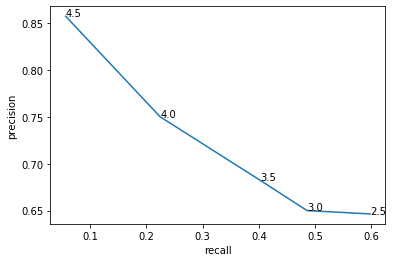

In [26]:
tresholds = [2.5, 3.0, 3.5, 4.0, 4.5]

def plot_precision_recall(prediction, tresholds):
    recalls = []
    precisons = []
    for treshold in tresholds:
        confusion = get_confusion(prediction, treshold)
        precisons.append(precision(confusion))
        recalls.append(recall(confusion))
    
    plt.plot(recalls, precisons)
    for r, p, t in zip(recalls, precisons, tresholds):
        plt.text(r, p, t)
        


plt.xlabel('recall')
plt.ylabel('precision')        
plot_precision_recall(review_predicted_item_based, tresholds)        